In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

In [2]:

# Define TSP
n_customer = 5
n_point = n_customer + 1

# 재현성을 위한 시드 고정
np.random.seed(0)

# 무작위 좌표 생성
df = pd.DataFrame({
    'x': np.random.randint(0, 100, n_point),
    'y': np.random.randint(0, 100, n_point),
})

# 출발점(0번 고객)의 좌표를 (0, 0)으로 고정 — 안전한 방식
df.loc[0, 'x'] = 0
df.loc[0, 'y'] = 0

# 결과 출력
df


,x,y
0,0,0
1,47,21
2,64,36
3,67,87
4,67,70
5,9,88


In [3]:
# Get the distance matrix
from scipy.spatial import distance_matrix
#import seaborn as sns
distances = pd.DataFrame(distance_matrix(df[['x', 'y']].values, df[['x', 'y']].values), index=df.index, columns=df.index).values

#fig, ax = plt.subplots(figsize=(13, 11))
#sns.heatmap(distances, ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=True, cbar_kws={"shrink": .3}, linewidths=.1)
#plt.title('distance matrix')
#plt.show()

In [4]:
max(sum(distances))

420.0731971025415

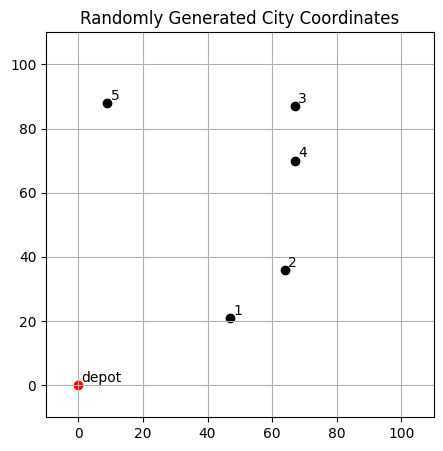

In [5]:
# Check TSP state

plt.figure(figsize=(5, 5))

# Draw the problem state
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'depot')
    else:
        plt.scatter(row['x'], row['y'], c='black')
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}')

plt.xlim([-10, 110])
plt.ylim([-10, 110])
#plt.title('points: id')
plt.title('Randomly Generated City Coordinates')
plt.grid(True)
plt.show()

In [6]:
# 결과 확인
print(distances)

[[  0.          51.4781507   73.430239   109.80892496  96.89685237
   88.45903006]
 [ 51.4781507    0.          22.6715681   68.9637586   52.92447449
   77.02596965]
 [ 73.430239    22.6715681    0.          51.0881591   34.13209633
   75.69015788]
 [109.80892496  68.9637586   51.0881591    0.          17.
   58.00862005]
 [ 96.89685237  52.92447449  34.13209633  17.           0.
   60.7289058 ]
 [ 88.45903006  77.02596965  75.69015788  58.00862005  60.7289058
    0.        ]]


In [7]:
from dimod import ConstrainedQuadraticModel, CQM, Binary, quicksum, BinaryQuadraticModel, ExactCQMSolver
from dwave.samplers import SteepestDescentSampler, SimulatedAnnealingSampler
import dimod
import neal
import numpy as np
#import greedy

In [8]:
from pyqubo import Array, Placeholder, Constraint

In [9]:
def tsp_pyqubo(n_point, distances, penalty=100.0):
    # 1. 이진 변수 선언
    x = Array.create('c', shape=(n_point, n_point), vartype='BINARY')

    # 2. Constraint 1: 각 도시 i는 정확히 한 번 방문
    time_const = 0.0
    for i in range(n_point):
        time_const += Constraint((sum(x[i, j] for j in range(n_point)) - 1)**2, label=f"time_{i}")

    # 3. Constraint 2: 각 위치 j에는 정확히 한 도시만 위치
    city_const = 0.0
    for j in range(n_point):
        city_const += Constraint((sum(x[i, j] for i in range(n_point)) - 1)**2, label=f"city_{j}")

    # 4. 목적 함수: 이동 거리 최소화
    distance_term = 0.0
    for i in range(n_point):
        for j in range(n_point):
            for k in range(n_point):
                distance_term += distances[i][j] * x[i, k] * x[j, (k + 1) % n_point]

    # 5. 전체 해밀토니안
    A = Placeholder("A")
    H = distance_term + A * (time_const + city_const)

    # 6. QUBO로 컴파일 및 변환
    model = H.compile()
    feed_dict = {"A": penalty}
    bqm = model.to_bqm(feed_dict=feed_dict)

    return model, bqm, feed_dict

In [ ]:
penalty = max(sum(distances))#100.0
pyqubo_model, pyqubo_bqm, pyqubo_feed_dict = tsp_pyqubo(n_point, distances, penalty=penalty)


In [11]:
max_bias = max(-pyqubo_bqm.linear.min(), pyqubo_bqm.linear.max())
max_bias = max(-pyqubo_bqm.quadratic.min(), pyqubo_bqm.quadratic.max(), max_bias)
print(max_bias)

840.146394205083


In [ ]:
import os, time, statistics
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from pyqubo import Array, Placeholder, Constraint
from dwave.system import DWaveCliqueSampler

# -----------------------------
# D-Wave 접속 설정 
# -----------------------------
endpoint = 'https://cloud.dwavesys.com/sapi'
token    = '--' # Use Token
solver   = 'Advantage2_system1.6'   # 또는 {'topology__type': 'zephyr'}

# -----------------------------
# TSP 데이터셋 + PyQUBO 빌더
# -----------------------------
def build_tsp_data(n_customer, seed=0):
    n_point = n_customer + 1
    rng = np.random.default_rng(seed)
    df = pd.DataFrame({
        'x': rng.integers(0, 100, n_point),
        'y': rng.integers(0, 100, n_point),
    })
    # 시작점 고정
    df.loc[0, 'x'] = 0
    df.loc[0, 'y'] = 0
    D = distance_matrix(df[['x','y']].values, df[['x','y']].values)
    return n_point, df, D

def tsp_pyqubo(n_point, distances, penalty):
    # 1) 변수
    x = Array.create('c', shape=(n_point, n_point), vartype='BINARY')
    # 2) 각 도시 1회 방문
    time_const = 0.0
    for i in range(n_point):
        time_const += Constraint((sum(x[i, j] for j in range(n_point)) - 1) ** 2, label=f"time_{i}")
    # 3) 각 위치에 한 도시
    city_const = 0.0
    for j in range(n_point):
        city_const += Constraint((sum(x[i, j] for i in range(n_point)) - 1) ** 2, label=f"city_{j}")
    # 4) 이동 거리
    distance_term = 0.0
    for i in range(n_point):
        for j in range(n_point):
            for k in range(n_point):
                distance_term += distances[i][j] * x[i, k] * x[j, (k + 1) % n_point]
    # 5) 전체 해밀토니안
    A = Placeholder("A")
    H = distance_term + A * (time_const + city_const)
    # 6) QUBO 변환
    model = H.compile()
    bqm = model.to_bqm(feed_dict={"A": penalty})
    return model, bqm

# -----------------------------
# Clique 임베딩 통계
# -----------------------------
def clique_embed_stats_for_bqm(bqm, cs, tag=""):
    """DWaveCliqueSampler.clique(variables)로 체인 길이/물리 큐비트 통계 반환."""
    L = len(bqm.variables)
    L_max = cs.largest_clique_size
    feasible = (L <= L_max)
    stats = {
        "tag": tag, "L": L, "L_max": L_max, "feasible": feasible
    }
    if not feasible:
        return stats, None

    variables = list(bqm.variables)
    t0 = time.time()
    emb = cs.clique(variables)  # {var: [phys_qubits]}
    elapsed = time.time() - t0

    lens = [len(emb[v]) for v in variables]
    stats.update({
        "n_chains": len(lens),
        "mean_chain": float(np.mean(lens)) if lens else 0.0,
        "max_chain": int(np.max(lens)) if lens else 0,
        "physical_qubits_sum": int(np.sum(lens)) if lens else 0,
        "elapsed_sec": elapsed
    })
    return stats, emb

# -----------------------------
# 메인: 문제 크기 sweep 후 Max 확인
# -----------------------------
def run_tsp_clique_sweep(n_customer_start=3, n_customer_stop=None, step=1, seed=0, content_tag="TSP"):
    cs = DWaveCliqueSampler(endpoint=endpoint, token=token, solver=solver)
    L_max = cs.largest_clique_size
    print(f"[info] largest_clique_size = {L_max}")

    # TSP의 변수 수는 n_point^2 이므로, n_point_max ≈ floor(sqrt(L_max))
    # (실제 pyqubo에서 변수 수를 직접 확인)
    est_n_point_max = int(np.floor(np.sqrt(L_max)))
    print(f"[info] estimated max n_point by L_max: {est_n_point_max}")

    rows = []
    tried = []

    # n_customer_stop 미지정이면 추정 최대 근방까지 검사
    if n_customer_stop is None:
        n_customer_stop = max(n_customer_start, est_n_point_max - 1)

    for n_customer in range(n_customer_start, n_customer_stop + 1, step):
        n_point, df, D = build_tsp_data(n_customer, seed=seed)
        penalty = float(np.max(np.sum(D, axis=1)))  # 한 도시에서 나가는 거리합 최대값 사용 (안정적인 큰 값)
        _, bqm = tsp_pyqubo(n_point, D, penalty=penalty)

        tag = f"{content_tag}_Ncust{n_customer}_Npoint{n_point}"
        stats, emb = clique_embed_stats_for_bqm(bqm, cs, tag=tag)
        stats["n_customer"] = n_customer
        stats["n_point"] = n_point
        rows.append(stats)
        tried.append((n_customer, len(bqm.variables), stats["feasible"]))

        print(f"\n[{tag}] vars={len(bqm.variables)} "
              f"feasible={stats['feasible']} "
              f"{'(skipped)' if not stats['feasible'] else ''}")
        if stats["feasible"]:
            print(f"  mean_chain={stats['mean_chain']:.3f}  max_chain={stats['max_chain']}  "
                  f"physical_qubits_sum={stats['physical_qubits_sum']}  time={stats['elapsed_sec']:.4f}s")

    # 추정 최대값 검증용으로 +1도 시도
    n_customer_try = est_n_point_max - 1  # 안전선
    for n_customer in [est_n_point_max, est_n_point_max + 1]:
        if n_customer < n_customer_start: 
            continue
        n_point, df, D = build_tsp_data(n_customer, seed=seed)
        penalty = float(np.max(np.sum(D, axis=1)))
        _, bqm = tsp_pyqubo(n_point, D, penalty=penalty)

        tag = f"{content_tag}_Ncust{n_customer}_Npoint{n_point}_edge"
        stats, emb = clique_embed_stats_for_bqm(bqm, cs, tag=tag)
        stats["n_customer"] = n_customer
        stats["n_point"] = n_point
        rows.append(stats)

        print(f"\n[{tag}] vars={len(bqm.variables)} feasible={stats['feasible']}")
        if stats["feasible"]:
            print(f"  mean_chain={stats['mean_chain']:.3f}  max_chain={stats['max_chain']}  "
                  f"physical_qubits_sum={stats['physical_qubits_sum']}  time={stats['elapsed_sec']:.4f}s")

    df_out = pd.DataFrame(rows).sort_values(["feasible","n_point","L"]).reset_index(drop=True)
    ts = int(time.time())
    out_csv = f"tsp_clique_embed_stats_{ts}.csv"
    df_out.to_csv(out_csv, index=False)
    print(f"\n[saved] {os.path.abspath(out_csv)}")

    # 요약: 최대 n_point
    feasible_rows = df_out[df_out["feasible"] == True]
    if len(feasible_rows):
        max_row = feasible_rows.iloc[feasible_rows["L"].argmax()]
        max_n_point = int(max_row["n_point"])
        max_L = int(max_row["L"])
        print(f"\n[RESULT] feasible up to n_point={max_n_point} (variables L={max_L} ≤ L_max={L_max})")
    else:
        print("\n[RESULT] no feasible n_point in tested range (increase range or check token/solver).")

    return df_out

# ==== 실행 예시 ====
if __name__ == "__main__":
    # n_customer_stop 조정
    df_stats = run_tsp_clique_sweep(n_customer_start=1, n_customer_stop=None, step=1, seed=0, content_tag="A2S1p6_Zephyr")


[info] largest_clique_size = 104
[info] estimated max n_point by L_max: 10

[A2S1p6_Zephyr_Ncust1_Npoint2] vars=4 feasible=True 
  mean_chain=1.000  max_chain=1  physical_qubits_sum=4  time=0.0084s

[A2S1p6_Zephyr_Ncust2_Npoint3] vars=9 feasible=True 
  mean_chain=2.444  max_chain=3  physical_qubits_sum=22  time=0.0075s

[A2S1p6_Zephyr_Ncust3_Npoint4] vars=16 feasible=True 
  mean_chain=2.500  max_chain=3  physical_qubits_sum=40  time=0.0071s

[A2S1p6_Zephyr_Ncust4_Npoint5] vars=25 feasible=True 
  mean_chain=3.520  max_chain=4  physical_qubits_sum=88  time=0.0080s

[A2S1p6_Zephyr_Ncust5_Npoint6] vars=36 feasible=True 
  mean_chain=4.472  max_chain=5  physical_qubits_sum=161  time=0.0082s

[A2S1p6_Zephyr_Ncust6_Npoint7] vars=49 feasible=True 
  mean_chain=5.449  max_chain=6  physical_qubits_sum=267  time=0.0071s

[A2S1p6_Zephyr_Ncust7_Npoint8] vars=64 feasible=True 
  mean_chain=6.500  max_chain=7  physical_qubits_sum=416  time=0.0085s

[A2S1p6_Zephyr_Ncust8_Npoint9] vars=81 feasible=T